# Tarea 2: Red Neuronal Perceptrón Multicapa con TensorFlow V2

## Cargamos las librerias

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

In [2]:
from tensorflow.keras.datasets.fashion_mnist import load_data
fashion_mnist = load_data()

## Extraemos los datos

In [3]:
(x_train, y_train), (x_test, y_test)=fashion_mnist

## Union de Datos

El dataset Fashion_Mnist cuenta con 60,000 imagenes de entrenamiento y 10,000 imagenes de prueba; Para los fines de esta tarea, se hara una división del dataset con una relación 30-70, es decir, %30 del dataset será destinado a test y %70 a entrenamiento.

In [4]:
X=np.concatenate((x_train,x_test))
Y=np.concatenate((y_train,y_test))

In [5]:
X=X.reshape(len(X),28*28).astype('float32')

## Codificación One Hot Encoding 

Las clases se representan con etiquetas numericas en el rango de $0,\cdots,9$:

<div align="center">

| Identificador 	| Clase 	|
|---	|---	|
| 0 	| T-shirt/top 	|
| 1 	| Trouser 	|
| 2 	| Pullover 	|
| 3 	| Dress 	|
| 4 	| Coat 	|
| 5 	| Sandal 	|
| 6 	| Shirt 	|
| 7 	| Sneaker 	|
| 8 	| Bag 	|
| 9 	| Ankle Boot 	|

</div>

Debido al identificador puede (o no) realizarse una codificación del tipo One Hot. Esta codificación permite que el modelo neuronal interprete la distancia entre identificadores de la misma forma, es decir, en un mal aprendizaje puede asociar la clase "Trouser" con la clase "Pullover" por que los identificadores son cercanos entre si, de forma comtraria es posible que interprete una relación (erronea) entre los identificadores mas separadas, lo cual no es relevante.

A fin de observar el efecto de la codificación se realizaran dos modelos: uno con codificación ONE HOT y otro sin ella.


In [6]:
ONE_HOT_ENC = OneHotEncoder(sparse=False)
Y_OHE = Y.reshape(len(Y), 1)
Y_OHE = ONE_HOT_ENC.fit_transform(Y_OHE)

In [7]:
print("Las dimensiones del vector de etiquetas son {}".format(Y.shape))
print("Los primeros 10 elementos son: \n {}".format(Y[0:10]))

Las dimensiones del vector de etiquetas son (70000,)
Los primeros 10 elementos son: 
 [9 0 0 3 0 2 7 2 5 5]


In [8]:
print("Los primeros 10 elementos codificados son: \n {}".format(Y_OHE[0:10]))

Los primeros 10 elementos codificados son: 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


## Arquitectura de el modelo

Se aprovecha el paradigma de la programación orientada a objetos de Python para desarrollar una instancia que permita la declaración de la arquitectura del modelo MLP.

In [9]:
class DNN_Model():
    def __init__(self,lenght_input,lenght_output):
        self.Layer_1_Weights=tf.Variable(np.random.rand(lenght_input,800),
                                         name="Layer_1_Weights",
                                         dtype="float32")
        self.Layer_1_Bias=tf.Variable(np.random.rand(800),
                                      name="Layer_1_Bias",
                                      dtype="float")
        self.Layer_2_Weights=tf.Variable(np.random.rand(800,950),
                                         name="Layer_2_Weights",
                                         dtype="float32")
        self.Layer_2_Bias=tf.Variable(np.random.rand(950),
                                      name="Layer_2_Bias",
                                      dtype="float")
        self.Layer_3_Weights=tf.Variable(np.random.rand(950,600),
                                         name="Layer_3_Weights",
                                         dtype="float32")
        self.Layer_3_Bias=tf.Variable(np.random.rand(600),
                                      name="Layer_3_Bias",
                                      dtype="float")
        self.Output_Layer_Weights=tf.Variable(np.random.rand(600,lenght_output),
                                              name="Output_Layer_Weights",
                                              dtype="float32")
        self.Output_Layer_Bias=tf.Variable(np.random.rand(lenght_output),
                                           name="Output_Bias",
                                           dtype="float32")
        self.Trainable_Variables=[self.Layer_1_Weights,
                                  self.Layer_1_Bias,
                                  self.Layer_2_Weights,
                                  self.Layer_2_Bias,
                                  self.Layer_3_Weights,
                                  self.Layer_3_Bias,
                                  self.Output_Layer_Weights,
                                  self.Output_Layer_Bias]
    def __call__(self,x):
        L1=tf.add(tf.matmul(x,self.Layer_1_Weights),self.Layer_1_Bias)
        L1=tf.nn.relu(L1)
        L2=tf.add(tf.matmul(L1,self.Layer_2_Weights),self.Layer_2_Bias)
        L2=tf.nn.relu(L2)
        L3=tf.add(tf.matmul(L2,self.Layer_3_Weights),self.Layer_3_Bias)
        L3=tf.nn.relu(L3)

        OutPut=tf.matmul(L3,self.Output_Layer_Weights)+self.Output_Layer_Bias

        return OutPut



In [10]:
optimizador=tf.compat.v1.train.AdamOptimizer(learning_rate=0.001)
train_loss=tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

## Configuración del gradiente

In [11]:
@tf.function
def train_step(model,tdata,labels):
    with tf.GradientTape() as tape:
        predictions=model(tdata)
        loss=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels,predictions))
    gradients=tape.gradient(loss,model.Trainable_Variables)
    capped_grads_and_vars=[(grad,model.Trainable_Variables[index]) for index, grad in enumerate(gradients)]
    optimizador.apply_gradients(capped_grads_and_vars)

    train_loss(loss)
    train_accuracy(labels,predictions)


In [12]:
@tf.function 
def test_step(model,tdata, labels):
  predictions = model(tdata)
  t_loss =  tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, predictions))

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [13]:
def fitting(model,train_x,train_y,test_x,test_y,EPOCHS,N_batch,batch_size):
  Train_L=[]
  Test_L=[]
  Train_A=[]
  Test_A=[]

  for epoch in range(EPOCHS):
    i=0
    while i+batch_size < len(train_x) or i+batch_size<batch_size*N_batch:
      start = i
      end = i+batch_size
      batch_x = train_x[start:end]
      batch_y = train_y[start:end]
      train_step(model,batch_x,batch_y)
      i+=batch_size
    test_step(model,test_x,test_y)


    
    template = 'Epoch {}, Perdida: {}, Exactitud: {}, Perdida de prueba: {}, Exactitud de prueba: {}'
    print(template.format(epoch+1,
                         train_loss.result(),
                        train_accuracy.result()*100,
                        test_loss.result(),
                        test_accuracy.result()*100))
    Train_L.append(train_loss.result())
    Train_A.append(train_accuracy.result())
    Test_L.append(test_loss.result())
    Test_A.append(test_accuracy.result())
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

  return (Train_A,Test_A),(Train_L,Test_L)
    

In [14]:
DNN=DNN_Model(lenght_input=28*28,lenght_output=10)
(Train_A,Test_A),(Train_L,Test_L)=fitting(DNN,X[0:5000],Y_OHE[0:5000],X[5000:6000],Y_OHE[5000:6000],50,100,50)

Epoch 1, Perdida: 6308946944.0, Exactitud: 10.161616325378418, Perdida de prueba: 1888437248.0, Exactitud de prueba: 10.40000057220459
Epoch 2, Perdida: 1859757056.0, Exactitud: 9.575757026672363, Perdida de prueba: 2264949760.0, Exactitud de prueba: 10.100000381469727
Epoch 3, Perdida: 2052447360.0, Exactitud: 10.606060981750488, Perdida de prueba: 1740179456.0, Exactitud de prueba: 10.300000190734863
Epoch 4, Perdida: 1352295552.0, Exactitud: 9.313131332397461, Perdida de prueba: 1406859776.0, Exactitud de prueba: 10.300000190734863
Epoch 5, Perdida: 969372096.0, Exactitud: 9.797980308532715, Perdida de prueba: 931395648.0, Exactitud de prueba: 9.600000381469727
Epoch 6, Perdida: 981862336.0, Exactitud: 10.525252342224121, Perdida de prueba: 769032896.0, Exactitud de prueba: 10.300000190734863
Epoch 7, Perdida: 699546304.0, Exactitud: 10.44444465637207, Perdida de prueba: 750302976.0, Exactitud de prueba: 9.600000381469727
Epoch 8, Perdida: 594092544.0, Exactitud: 9.616162300109863, 

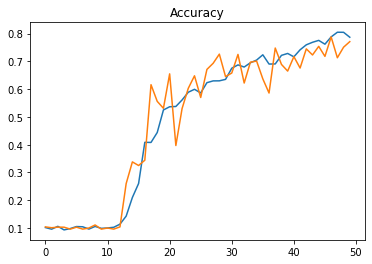

In [15]:
plt.plot(Train_A)
plt.plot(Test_A)
plt.title("Accuracy")
plt.show()


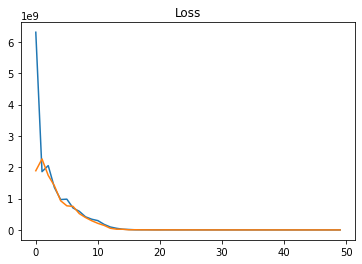

In [16]:
plt.plot(Train_L)
plt.plot(Test_L)
plt.title("Loss")
plt.show()